In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
import scipy
from sklearn.model_selection import cross_validate

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [66]:
def analysis(data: pd.DataFrame):
    data = pd.DataFrame.copy(data)
    data = split_date_time(data)
    
    columns = data.columns
    fig, axes = plt.subplots(len(data.columns), 1, figsize=(10, 40))
    
    for i, col in enumerate(columns):
        axes[i].hist(data[col], color='skyblue', edgecolor='black')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('frequency')

    plt.tight_layout()
    plt.show()
    

def get_date_features(x):
    x_datetime = datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S')
    year = x_datetime.year
    month = x_datetime.month
    day = x_datetime.day
    hour = x_datetime.hour
    
    return [year, month, day, hour]


def split_date_time(data: pd.DataFrame):
    date_values= np.stack(data['date_time'].apply(lambda x: get_date_features(x)).values)
    data['year'] = date_values[:, 0]
    data['month'] = date_values[:, 1]
    data['day'] = date_values[:, 2]
    data['hour'] = date_values[:, 3]
    data = data.drop(columns=['date_time'])
    return data


def feature_engineering(data: pd.DataFrame, min_frequency=100) -> pd.DataFrame:    
    # Разобью столбец date_time на год/месяц/день/час
    # Минуты и секунды я дропаю, тк кажется, что эти значения не могут нести полезной информации
    data = split_date_time(data)
    
    # Удалю константные фичи
    data = data.drop(columns=['impressions', 'year'])
    
    #Удалю дубликаты
    data = data.drop_duplicates()

    # Добавлю новые фичи: конкатенация всех категориальных фичей
    # Смысл такой, что у нас в определенной зоне в определенное время может быть больше кликов и т.д.
    cols = ['zone_id', 'banner_id', 'os_id', 'country_id', 'month', 'day', 'hour']
    for i in range(len(cols) - 1):
        for j in range(i + 1, len(cols)):
            column_i = cols[i]
            column_j = cols[j]
            data[f'{column_i}_{column_j}'] = f'{data[column_i]}_{data[column_j]}'
#             a[f'{column_i}*{column_j}'] = column_i*column_j

    
    # Выделим индексы последнего дня (10 месяц, 2 день) -- наш тест
    last_day_indices = np.logical_and((data['month'] == 10).values, (data['day'] == 2).values)
    train_data, test_data = data[np.logical_not(last_day_indices)], data[last_day_indices]
    
    X_train, y_train = train_data.drop(columns=['clicks']), train_data['clicks']
    X_test, y_test = test_data.drop(columns=['clicks']), test_data['clicks']

    # Категориальные фичи -> one_hot с min_frequency, который я подбираю
    enc = OneHotEncoder(handle_unknown='ignore', min_frequency=min_frequency)
    X_categorical_train = enc.fit_transform(X_train.drop(columns=['campaign_clicks']))
    X_categorical_test = enc.transform(X_test.drop(columns=['campaign_clicks']))
    
    # Числовые -> StandartScaler
    ss = StandardScaler()
    X_numerical_train = ss.fit_transform(X_train[['campaign_clicks']])
    X_numerical_test = ss.transform(X_test[['campaign_clicks']])
    
    X_train = scipy.sparse.hstack((X_categorical_train, X_numerical_train))
    X_test = scipy.sparse.hstack((X_categorical_test, X_numerical_test))

    X_val, y_val = None, None
#     # Split для валидации
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
        
    # Т.к данные имбалансные делаю downsampling по меньшему классу
    # Изначально я использовал SMOTE, но он работает вечность
    os = RandomOverSampler(random_state=42)
    X_train, y_train = os.fit_resample(X_train, y_train)
        
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    
def create_model(X, y, C=0.01):
    model = LogisticRegression(solver='liblinear', C=C)
#     model.fit(X, y)
    
    return model

def count_metrics(y_test, y_pred):
    return log_loss(y_test, y_pred), roc_auc_score(y_test, y_pred)

def validate_model(X, y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    log_loss, roc_auc = count_metrics(y, y_pred_proba)
    return log_loss, roc_auc


In [3]:
all_data = pd.read_csv('data.csv')
all_data = all_data.drop(columns=['oaid_hash', 'banner_id0', 'banner_id1',\
                              'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])

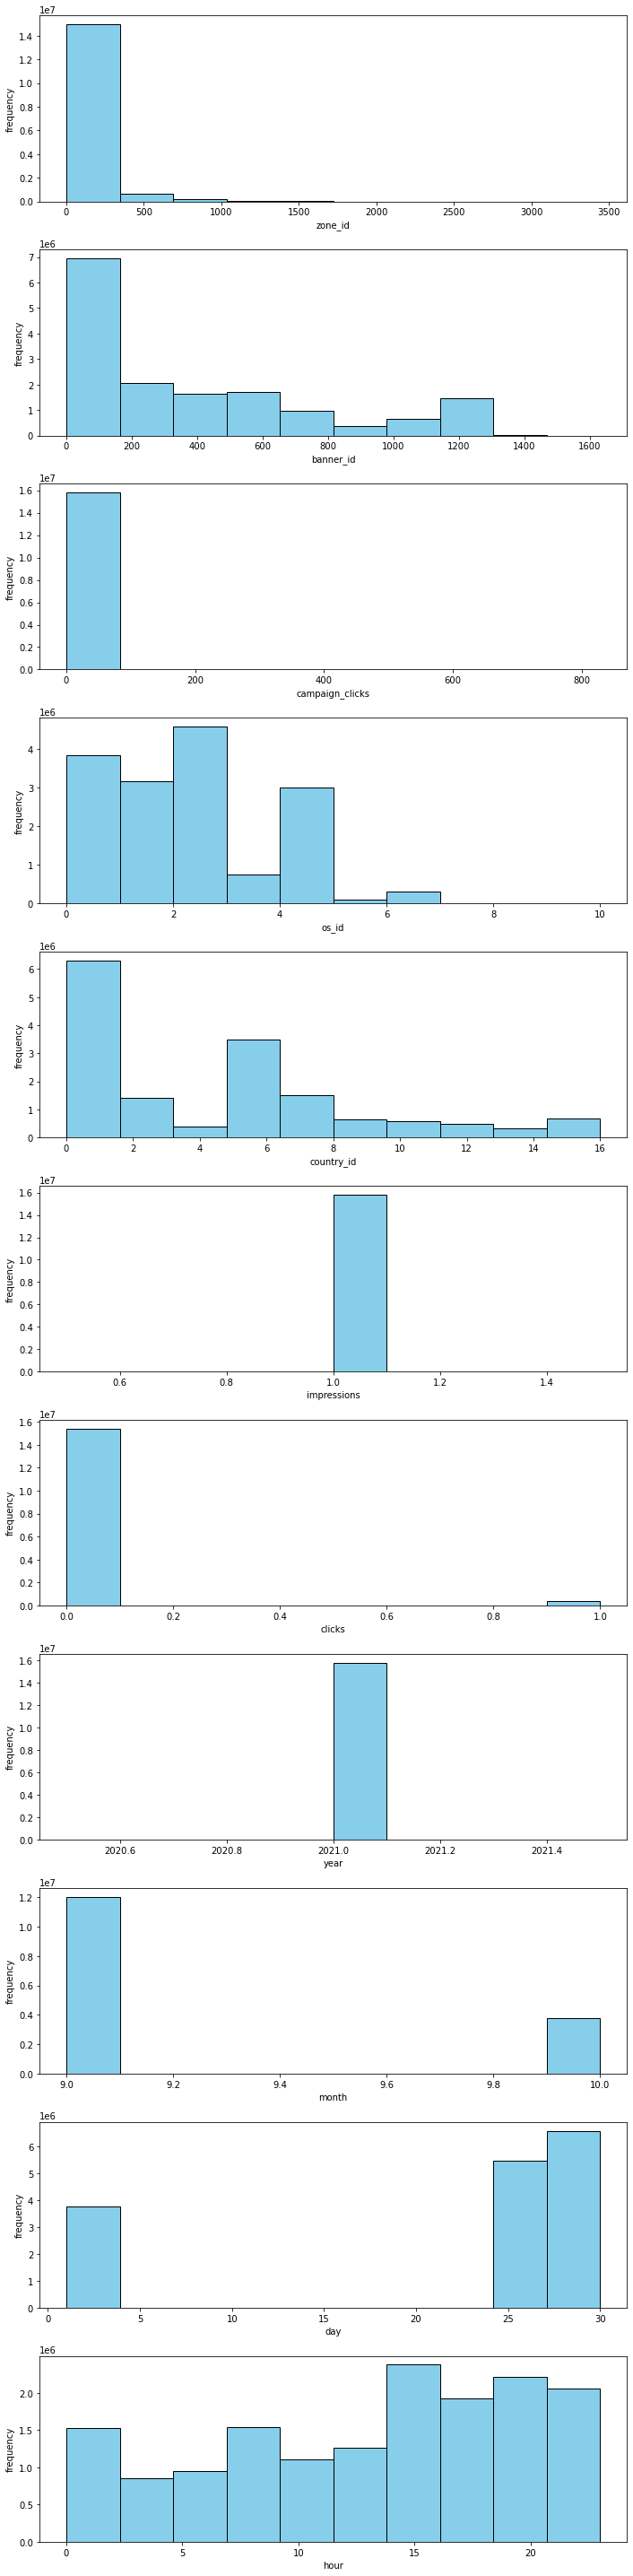

In [14]:
analysis(all_data)

In [38]:
# Подберём лучшее значение для min_frequency (на части датасета)

cv_array = []

for log_min_frequency in range(16):
    min_frequency = 2 ** log_min_frequency
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = feature_engineering(all_data.sample(500000),\
                                                                               min_frequency)
    model = create_model(X_train, y_train)
    cv = cross_validate(model, X_train, y_train, scoring=['roc_auc', 'neg_log_loss'], cv=5)
    cv_array.append(cv)

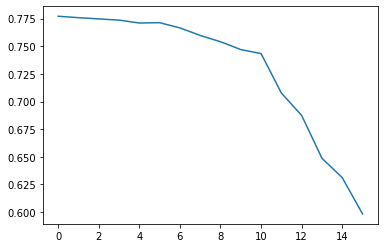

In [39]:
# выбрал значение 2**0 == 1, тк значение метрики равно максимуму
roc_auc_avg = [np.mean(item['test_roc_auc']) for item in cv_array]
plt.plot(roc_auc_avg)

In [42]:
# Подберём лучшее значение для С (на части датасета)

cv_array = []

for log_С in range(6):
    C = 0.1 ** log_С
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = feature_engineering(all_data.sample(500000),\
                                                                               min_frequency=32)
    model = create_model(X_train, y_train, C=C)
    cv = cross_validate(model, X_train, y_train, scoring=['roc_auc'], cv=5)
    cv_array.append(cv)

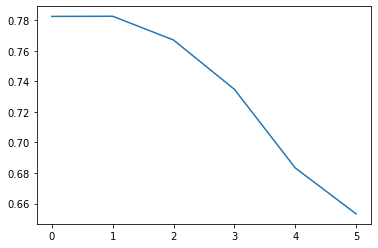

In [43]:
# Лучшее значение C = 1
roc_auc_avg = [np.mean(item['test_roc_auc']) for item in cv_array]
plt.plot(roc_auc_avg)

In [80]:
# Обучим итоговую модель на всех данных min_frequency=1, C=1
(X_train, y_train), (X_val, y_val), (X_test, y_test) = feature_engineering(all_data, min_frequency=1)
model = create_model(X_train, y_train, C=1)
model.fit(X_train, y_train)

LogisticRegression(C=1, solver='liblinear')

In [81]:
# Итоговый скор на последнем дне
validate_model(X_test, y_test, model)

(0.7225271872729148, 0.7550432223404697)

In [83]:
# Сравним с бейзлайном
y_baseline = np.ones_like(y_test) * np.mean(y_test)
count_metrics(y_test, y_baseline)

(0.26697782521928803, 0.5)

In [ ]:
# Кажется, из-за того, что я семплирую меньший класс, я меняю распределение по кликам в тесте
# Тогда оценка по log_loss искажается
# Но roc_auc неплохой, кажется